/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/manohar/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


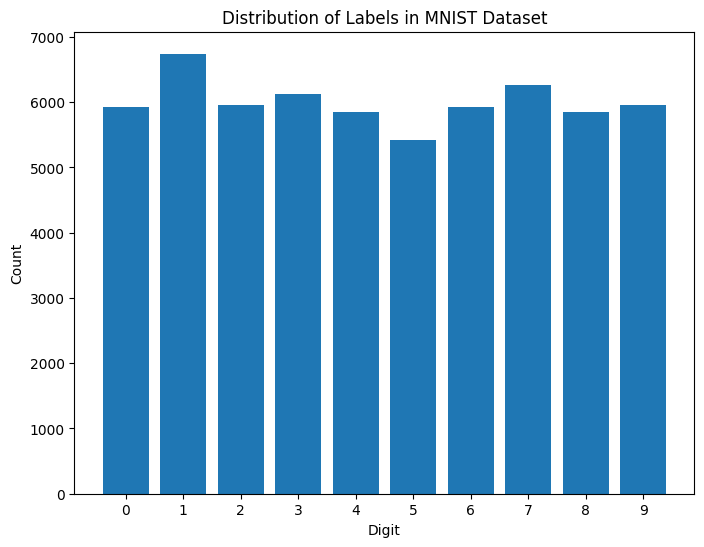

In [2]:
# 4.1
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

labels = mnist_dataset.targets.numpy()

label_counts = torch.bincount(torch.tensor(labels))

plt.figure(figsize=(8, 6))
plt.bar(range(10), label_counts, tick_label=range(10))
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("Distribution of Labels in MNIST Dataset")
plt.show()


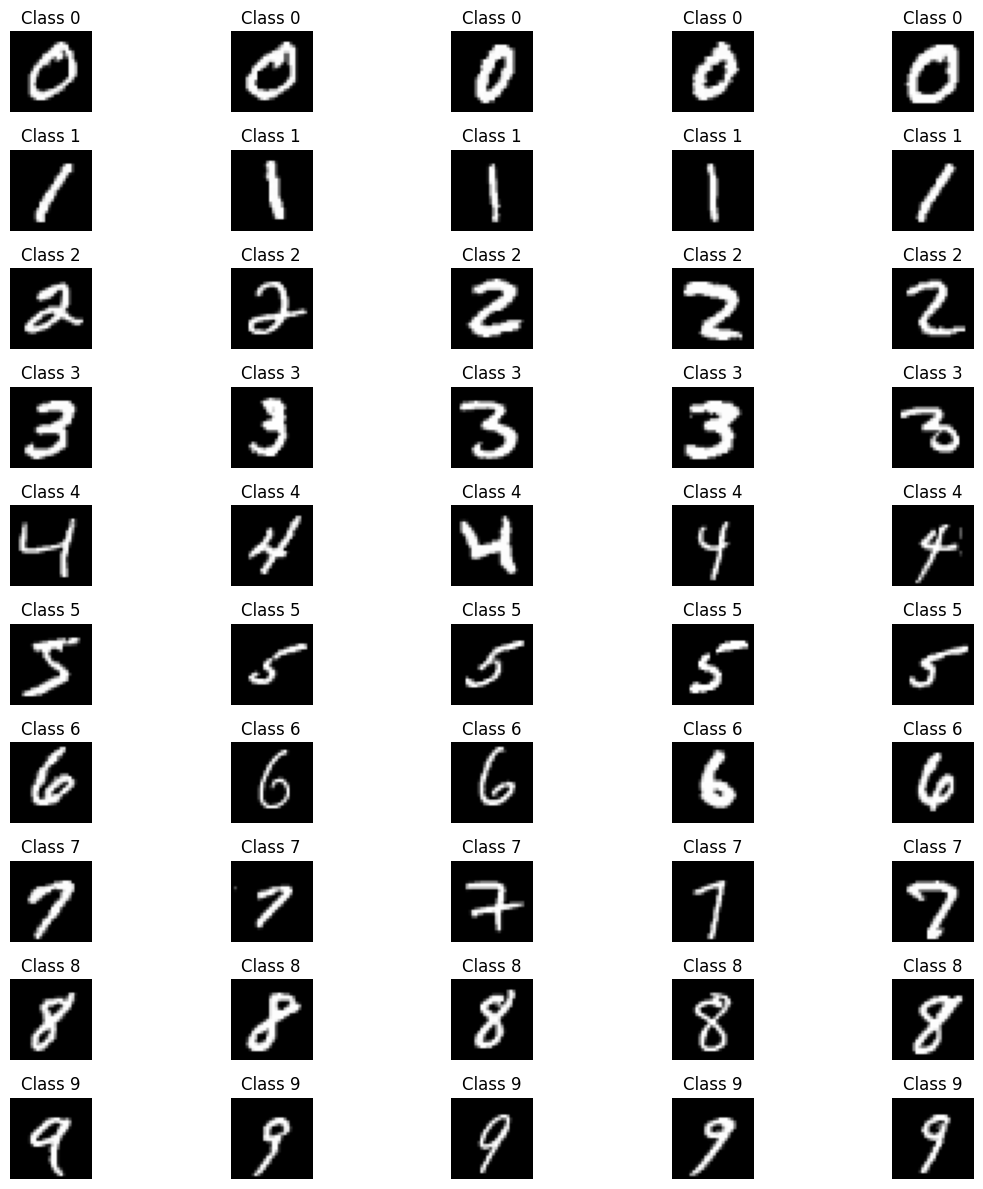

In [3]:
class_images = {i: [] for i in range(10)}

for data, target in mnist_dataset:
    if all(len(class_images[i]) >= 5 for i in range(10)):
        break
    class_images[target].append(data)

plt.figure(figsize=(12, 12))
for class_id, images in class_images.items():
    for i in range(5):
        plt.subplot(10, 5, class_id * 5 + i + 1)
        plt.axis('off')
        image = (images[i].squeeze().numpy() * 0.5) + 0.5  # Reshape and normalize
        plt.imshow(image, cmap='gray')
        plt.title(f'Class {class_id}')

plt.tight_layout()
plt.show()

In [4]:
min_count = label_counts.min().item()
max_count = label_counts.max().item()
class_imbalance = (max_count - min_count) / min_count * 100

print(f"Class with the minimum examples: Class {label_counts.argmin()}")
print(f"Class with the maximum examples: Class {label_counts.argmax()}")
print(f"Class imbalance percentage: {class_imbalance:.2f}%")


Class with the minimum examples: Class 5
Class with the maximum examples: Class 1
Class imbalance percentage: 24.37%


In [5]:
import torchvision
import random

def visualize_feature_maps(model, input_image, layer_name):
    model.eval()

    target_layer = None
    for name, layer in model.named_modules():
        if name == layer_name:
            target_layer = layer

    if target_layer is None:
        print(f"Layer '{layer_name}' not found in the model.")
        return

    feature_maps = None
    def hook(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    hook_handle = target_layer.register_forward_hook(hook)

    with torch.no_grad():
        model(input_image)

    hook_handle.remove()

    num_feature_maps = feature_maps.size(1)
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(16, 4))

    for i in range(num_feature_maps):
        ax = axes[i]
        feature_map = feature_maps[0, i].cpu().detach().numpy()
        ax.imshow(feature_map, cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Feature Map {i}")

    plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class BaselineCNN(nn.Module):
    def __init__(self, num_classes,kernel_sizes,strides,dropout_rate=0.5,use_dropout=True,input_size=28):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_sizes[0], padding=int((kernel_sizes[0]-1)/2))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=kernel_sizes[1], stride=strides[0])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_sizes[2], padding=int((kernel_sizes[2]-1)/2))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=kernel_sizes[3], stride=strides[1])
        self.feature_map_size  = self.calculate_final_feature_map_size(input_size,kernel_sizes[0],kernel_sizes[2],kernel_sizes[1],strides[0],kernel_sizes[3],strides[1])
        self.fc1 = nn.Linear(64 * self.feature_map_size*self.feature_map_size, 128)  
        if use_dropout:
            self.dropout = nn.Dropout(dropout_rate)
        else:
            self.dropout = None
    
        self.fc2 = nn.Linear(128, num_classes)

    def calculate_final_feature_map_size(self,input_size, conv1_kernel_size, conv2_kernel_size, pool1_size, pool1_stride, pool2_size, pool2_stride):
        conv1_output_size = input_size 
        pool1_output_size = int((conv1_output_size - pool1_size) / pool1_stride + 1)
        conv2_output_size = pool1_output_size 
        pool2_output_size = (conv2_output_size - pool2_size) / pool2_stride + 1
        return int(pool2_output_size)
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        if self.dropout is not None:
            x = self.dropout(x)
            
        x = self.fc2(x)
        return x

In [7]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_dataset, val_dataset = train_test_split(train_dataset,test_size=0.2,random_state=42)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
num_classes = 10
kernel_sizes = [5,2,5,2]
strides = [1,2]
model = BaselineCNN(num_classes,kernel_sizes,strides)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/manohar/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


BaselineCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
train_losses = []       
train_accuracies = []   
val_losses = []         
val_accuracies = []     

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    #   Train
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / (i + 1)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0

    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1, Training Loss: 0.1541, Training Accuracy: 95.24%, Validation Loss: 0.0480, Validation Accuracy: 98.42%
Epoch 2, Training Loss: 0.0636, Training Accuracy: 98.07%, Validation Loss: 0.0351, Validation Accuracy: 98.97%
Epoch 3, Training Loss: 0.0451, Training Accuracy: 98.65%, Validation Loss: 0.0371, Validation Accuracy: 98.88%


In [9]:
# 4.1.5
import cv2

def visualize_feature_maps(model, layer_name, input_image, class_index):
    target_layer = None
    for name, layer in model.named_modules():
        if name == layer_name:
            target_layer = layer

    if target_layer is None:
        print(f"Layer '{layer_name}' not found in the model.")
        return

    feature_maps = None
    def hook(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    hook_handle = target_layer.register_forward_hook(hook)

    with torch.no_grad():
        model(input_image)

    hook_handle.remove()

    class_feature_maps = feature_maps[0, class_index].cpu().detach().numpy()

    num_feature_maps = class_feature_maps.shape[0]

    num_cols = 8  
    num_rows = (num_feature_maps + num_cols - 1) // num_cols

    resize_dim = 10  

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
    fig.suptitle(f"Feature Maps for Class {class_index} in Layer {layer_name}")

    for i in range(num_feature_maps):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        resized_feature_map = cv2.resize(class_feature_maps[i], (resize_dim, resize_dim))

        ax.imshow(resized_feature_map, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Feature Map {i}")

    for i in range(num_feature_maps, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

    plt.show()


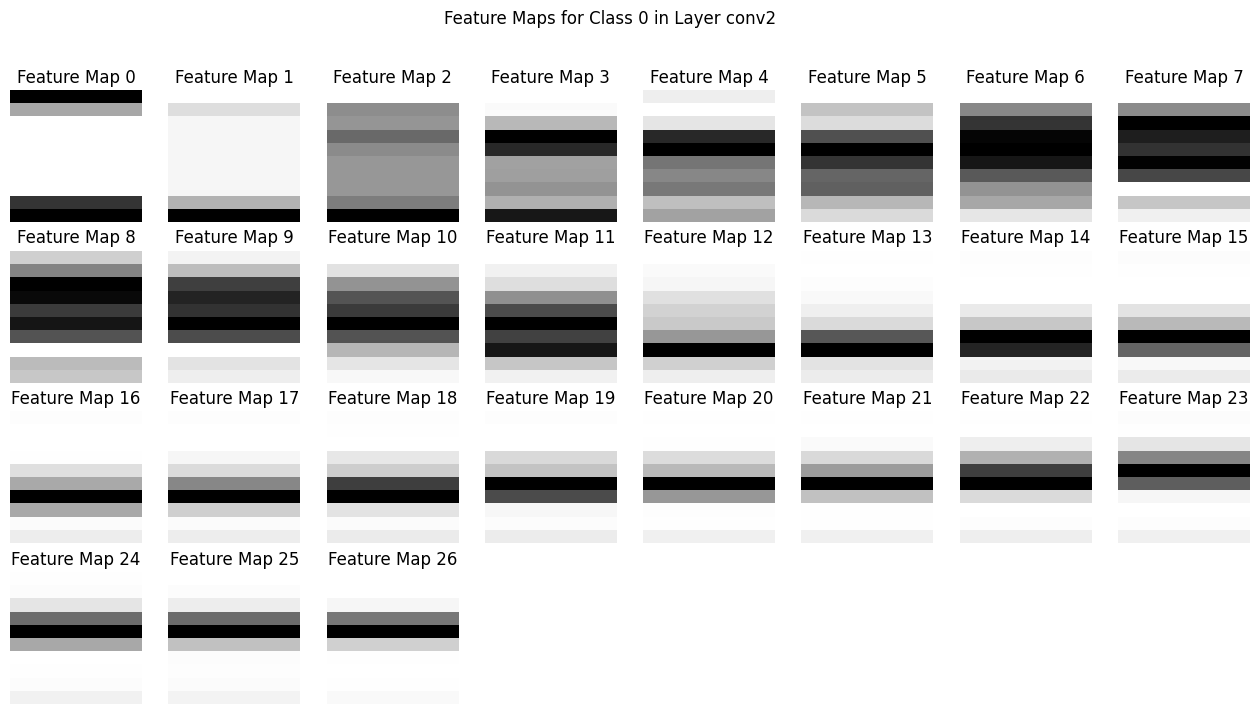

In [10]:
class_index_to_visualize = 0
input_image = test_dataset[class_index_to_visualize][0].unsqueeze(0).to(device)
visualize_feature_maps(model, "conv2", input_image, class_index_to_visualize)

 **colormap**
- Higher the black higher intensity
- Lighter the black lower intensity

**Observations:**
- We observe that for $conv2$ layer the feature maps have higher values in the class which they belong to.

In [11]:
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(model, data_loader):
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())
    
    return confusion_matrix(all_labels, all_predictions)

def calculate_class_metrics(confusion_mat):
    num_classes = len(confusion_mat)
    class_metrics = []

    for class_id in range(num_classes):
        true_positives = confusion_mat[class_id, class_id]
        false_positives = sum(confusion_mat[:, class_id]) - true_positives
        false_negatives = sum(confusion_mat[class_id, :]) - true_positives

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1 = 2 * (precision * recall) / (precision + recall)

        class_metrics.append((precision, recall, f1))

    return class_metrics



In [12]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import wandb
import itertools

wandb.init(project="smai_a3")

learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
kernel_sizes = [[5,2,5,2], [3,2,3,2], [7,2,7,2], [5,3,5,3], [3,3,3,3]]
strides = [[1,2], [2,2], [1,1], [2,1]]
num_epochs = [5, 10, 15]
dropout_rates = [0.0, 0.25, 0.5]

config = wandb.config

best_accuracy = 0
best_hyperparameters = {}

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

train_dataset, val_dataset = train_test_split(train_dataset,test_size=0.2,random_state=42)


best_accuracy = 0

for lr, batch_size, kernel_size, stride, epochs, dropout in itertools.product(
        learning_rates, batch_sizes, kernel_sizes, strides, num_epochs, dropout_rates):

    config.learning_rate = lr
    config.batch_size = batch_size
    config.kernel_size = kernel_size
    config.stride = stride
    config.num_epochs = epochs
    config.dropout_rate = dropout


    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size)

    num_classes = 10
    model = BaselineCNN(num_classes,config.kernel_size,config.stride,config.dropout_rate)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    # Training and validation loop
    for epoch in range(config.num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / (i + 1)
        train_accuracy = 100 * correct_train / total_train

        correct_val = 0
        total_val = 0
        running_val_loss = 0.0

        model.eval()
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        # Log metrics to W&B
        wandb.log({"epoch": epoch, "train_loss": train_loss, "train_accuracy": train_accuracy,
                "val_loss": val_loss, "val_accuracy": val_accuracy})

        # Log confusion matrix
        # confusion_mat = calculate_confusion_matrix(model, test_loader)
        # if confusion_mat is not None and confusion_mat.any():
        #     wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(confusion_mat)})
        #     # Log class-specific metrics (precision, recall, F1-score)
        #     class_metrics = calculate_class_metrics(confusion_mat)
        #     for i, (precision, recall, f1_score) in enumerate(class_metrics):
        #         wandb.log({f"class_{i}_precision": precision, 
        #                 f"class_{i}_recall": recall, 
        #                 f"class_{i}_f1_score": f1_score})

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_hyperparameters = {
                "learning_rate": lr,
                "batch_size": batch_size,
                "kernel_size": kernel_size,
                "stride": stride,
                "num_epochs": epochs,
                "dropout_rate": dropout
            }
            torch.save(model.state_dict(), "best_model.pth")

print("Training finished")
wandb.finish()

# Log the best hyperparameters to W&B
wandb.run.summary["best_hyperparameters"] = best_hyperparameters
wandb.finish()  # Finish the W&B run


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: manoharnaga333 (stabber). Use `wandb login --relogin` to force relogin


In [13]:
dropout_rates = [0.25, 0.5]

def get_dropout_outputs(dropout_rate_val,is_dropout):
    num_classes = 10  
    kernel_sizes = [5,2,5,2]
    strides = [1,2]
    model = BaselineCNN(num_classes,kernel_sizes,strides,dropout_rate_val,is_dropout)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []       
    train_accuracies = []   
    val_losses = []         
    val_accuracies = []     

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Train
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / (i + 1)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validate
        correct_val = 0
        total_val = 0
        running_val_loss = 0.0

        model.eval()
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return val_accuracies

dropout_rates = [0.25, 0.5]
dropout_outputs = []

for dropout_rate in dropout_rates:
    val_accuracy_with_dropout_list = get_dropout_outputs(dropout_rate,True)
    val_accuracy_no_dropout_list = get_dropout_outputs(dropout_rate,False)
    num_epochs = len(val_accuracy_with_dropout_list)
    for epoch in range(num_epochs):
        dropout_outputs.append({
            'Epoch': epoch+1,
            'Validation Accuracy (With Dropout)': val_accuracy_with_dropout_list[epoch],
            'Validation Accuracy (No Dropout)': val_accuracy_no_dropout_list[epoch]
        })
    
    print(f"Dropout Rate: {dropout_rate}")
    for entry in dropout_outputs:
        print(f"Epoch: {entry['Epoch']}, Validation Accuracy (With Dropout): {entry['Validation Accuracy (With Dropout)']:.2f}%, Validation Accuracy (No Dropout): {entry['Validation Accuracy (No Dropout)']:.2f}%")
        wandb.log({"dropout_rate": dropout_rate, 
                "epoch": entry['Epoch'],
                "with_dropout_val_accuracy": entry['Validation Accuracy (With Dropout)'], 
                "no_dropout_val_accuracy": entry['Validation Accuracy (No Dropout)']})
    
wandb.finish()


Dropout Rate: 0.25
Epoch: 1, Validation Accuracy (With Dropout): 98.15%, Validation Accuracy (No Dropout): 98.50%
Epoch: 2, Validation Accuracy (With Dropout): 98.18%, Validation Accuracy (No Dropout): 98.71%
Dropout Rate: 0.5
Epoch: 1, Validation Accuracy (With Dropout): 98.15%, Validation Accuracy (No Dropout): 98.50%
Epoch: 2, Validation Accuracy (With Dropout): 98.18%, Validation Accuracy (No Dropout): 98.71%
Epoch: 1, Validation Accuracy (With Dropout): 98.53%, Validation Accuracy (No Dropout): 98.38%
Epoch: 2, Validation Accuracy (With Dropout): 99.03%, Validation Accuracy (No Dropout): 98.42%


dropout_rate,▁▁████
epoch,▁█▁█▁█
no_dropout_val_accuracy,▄█▄█▁▂
with_dropout_val_accuracy,▁▁▁▁▄█
dropout_rate,0.5
epoch,2
no_dropout_val_accuracy,98.425
with_dropout_val_accuracy,99.03333


### Comparing Dropout vs. No Dropout

1. **Reduced Overfitting**: Dropout layers help prevent overfitting by randomly deactivating neurons during training. This leads to a more generalized model that performs better on unseen data.

2. **Improved Training Speed**: Models without dropout layers may train faster, but they are more prone to overfitting. Dropout can slow down training but typically results in better performance and robustness.

3. **Balancing Complexity**: The decision to use dropout depends on the dataset and model complexity. Simple datasets and models may not require dropout, while more complex scenarios can benefit from dropout to enhance generalization.

In [14]:
# 4.4
from sklearn.metrics import hamming_loss, classification_report

test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

true_labels = []
predicted_labels = []
misclassified_images = []

misclassified_sample = {
    'image': None,              # Store the image
    'true_label': None,         # Store the true label
    'predicted_label': None     # Store the predicted label
}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.cpu().numpy()
        predicted = predicted.cpu().numpy()
        if not np.array_equal(predicted, labels):
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified_sample['image'] = images[i]
                    misclassified_sample['true_label'] = labels[i]
                    misclassified_sample['predicted_label'] = predicted[i]
                    misclassified_images.append(misclassified_sample.copy())

        true_labels.append(labels)
        predicted_labels.append(predicted)

true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

accuracy = 1-hamming_loss(true_labels, predicted_labels)
print("Accuracy:", accuracy * 100, "%")

classification_rep = classification_report(true_labels, predicted_labels, digits=4)
for class_idx, class_info in classification_rep.items():
    if class_idx.isdigit():
        class_idx = int(class_idx)
        class_accuracy = class_info['recall']  # Use 'recall' as it corresponds to accuracy
        print(f"Class {class_idx}: {class_accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_rep)

Accuracy: 99.11 %
Class 0: 99.39%
Class 1: 99.74%
Class 2: 99.81%
Class 3: 99.31%
Class 4: 98.68%
Class 5: 99.22%
Class 6: 99.06%
Class 7: 98.15%
Class 8: 98.67%
Class 9: 99.01%
Classification Report:
{'0': {'precision': 0.9928644240570846, 'recall': 0.9938775510204082, 'f1-score': 0.9933707292197859, 'support': 980}, '1': {'precision': 0.9929824561403509, 'recall': 0.9973568281938326, 'f1-score': 0.9951648351648352, 'support': 1135}, '2': {'precision': 0.9837631327602674, 'recall': 0.998062015503876, 'f1-score': 0.9908609908609908, 'support': 1032}, '3': {'precision': 0.9930693069306931, 'recall': 0.9930693069306931, 'f1-score': 0.9930693069306931, 'support': 1010}, '4': {'precision': 0.9979402677651905, 'recall': 0.9867617107942973, 'f1-score': 0.9923195084485406, 'support': 982}, '5': {'precision': 0.9899328859060402, 'recall': 0.992152466367713, 'f1-score': 0.9910414333706606, 'support': 892}, '6': {'precision': 0.9895724713242962, 'recall': 0.9906054279749478, 'f1-score': 0.990088

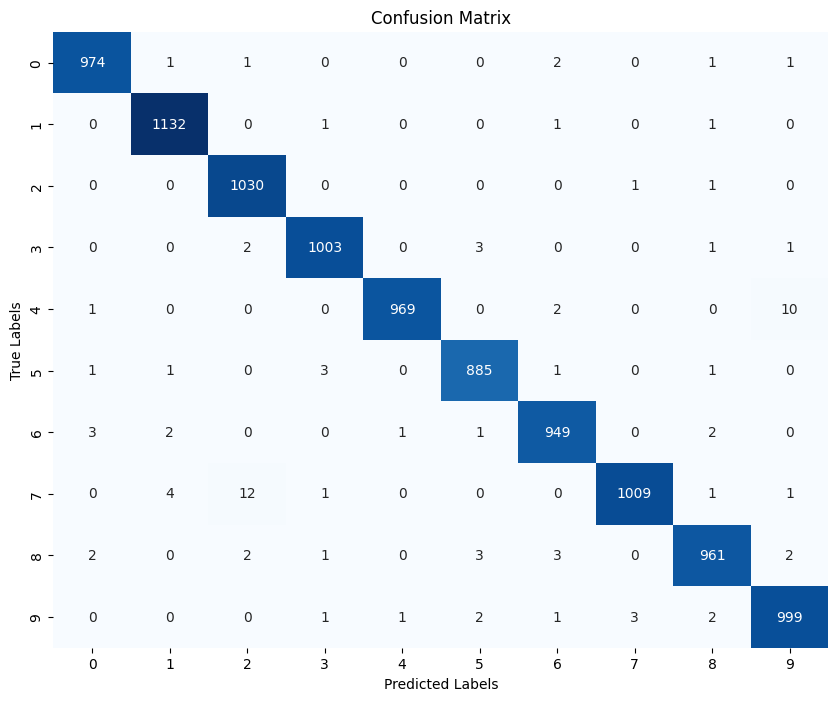

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

True Label: 4, Predicted Label: 6


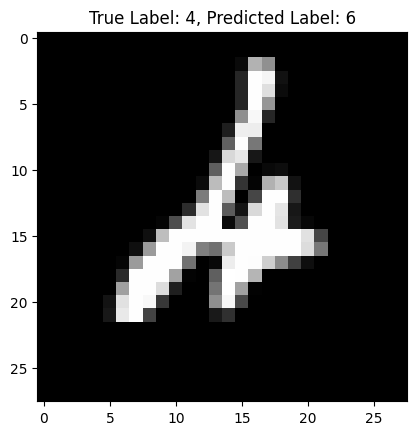

True Label: 6, Predicted Label: 0


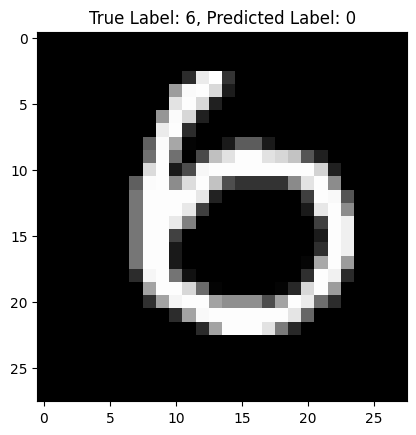

True Label: 1, Predicted Label: 8


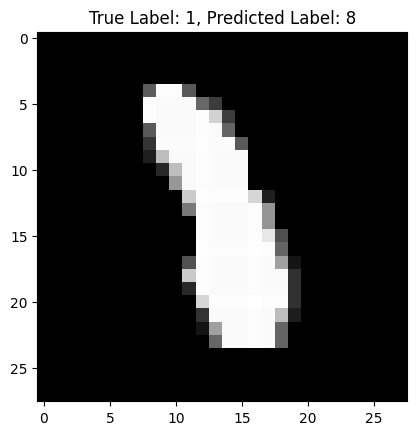

True Label: 0, Predicted Label: 6


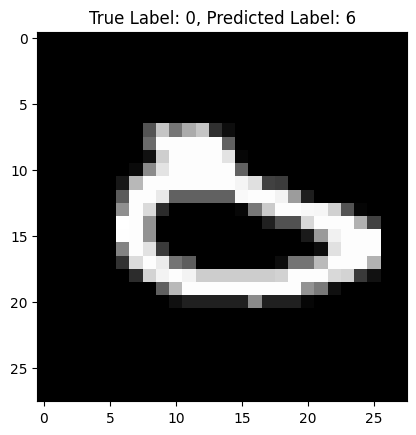

True Label: 4, Predicted Label: 9


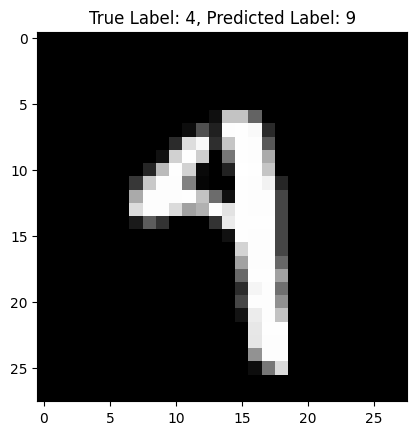

In [16]:
# Visualize and analyze misclassified images
counter = 0
for sample in misclassified_images:
    if counter == 5:
        break
    image = sample['image']
    true_label = sample['true_label']
    predicted_label = sample['predicted_label']
    image = image.cpu().numpy().squeeze()
    counter += 1
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.imshow(image, cmap='gray')
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.show()


**Possible reasons behind these misclassifications**
- The Samples are tilted by a very high angle to one side
- They look almost like both predicted and true label for humans as well
- The Samples are very far and very rare from original handwritten digits
- Missing Edges in samples, Ex:- missing 1/4th part in *8* which makes it look like 2.


In [20]:
# 4.5
import scipy.io
from sklearn.model_selection import train_test_split

mnist_data = scipy.io.loadmat('mnist-with-awgn.mat')

noisy_mnist_images = mnist_data['train_x']
mnist_labels = mnist_data['train_y']

X_test = mnist_data['test_x']
y_test = mnist_data['test_y']

X_train, X_val, y_train, y_val = train_test_split(noisy_mnist_images, mnist_labels, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32) / 255.0
X_val_tensor = torch.tensor(X_val, dtype=torch.float32) / 255.0
X_test_tensor = torch.tensor(X_test, dtype=torch.float32) / 255.0

X_train_tensor = X_train_tensor.view(-1, 1, 28, 28)
X_val_tensor = X_val_tensor.view(-1, 1, 28, 28)
X_test_tensor = X_test_tensor.view(-1, 1, 28, 28)

y_train_labels = torch.argmax(torch.tensor(y_train, dtype=torch.float32), dim=1).long()
y_val_labels = torch.argmax(torch.tensor(y_val, dtype=torch.float32), dim=1).long()
y_test_labels = torch.argmax(torch.tensor(y_test, dtype=torch.float32), dim=1).long()

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_labels)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_labels)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_labels)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

num_classes = 10
kernel_sizes = [5,2,5,2]
strides = [1,2]
model = BaselineCNN(num_classes,kernel_sizes,strides)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []       
train_accuracies = []   
val_losses = []         
val_accuracies = []     

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Train
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / (i + 1)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0

    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

print("Training and validation finished.")
print("Training Losses:", train_losses)
print("Training Accuracies:", train_accuracies)
print("Validation Losses:", val_losses)
print("Validation Accuracies:", val_accuracies)


Epoch 1, Training Loss: 0.3105, Training Accuracy: 90.38%, Validation Loss: 0.1153, Validation Accuracy: 96.42%
Epoch 2, Training Loss: 0.1254, Training Accuracy: 96.16%, Validation Loss: 0.0935, Validation Accuracy: 97.02%
Epoch 3, Training Loss: 0.1011, Training Accuracy: 96.76%, Validation Loss: 0.0864, Validation Accuracy: 97.27%
Training and validation finished.
Training Losses: [0.31053930058827, 0.1254000241147975, 0.10105370974602798]
Training Accuracies: [90.38125, 96.16041666666666, 96.75833333333334]
Validation Losses: [0.11533509431149255, 0.09347170469985205, 0.08637836432589734]
Validation Accuracies: [96.41666666666667, 97.01666666666667, 97.26666666666667]


In [21]:
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

report = classification_report(true_labels, predicted_labels,digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9711    0.9929    0.9818       980
           1     0.9739    0.9868    0.9803      1135
           2     0.9728    0.9709    0.9719      1032
           3     0.9880    0.9762    0.9821      1010
           4     0.9885    0.9664    0.9773       982
           5     0.9852    0.9686    0.9768       892
           6     0.9823    0.9843    0.9833       958
           7     0.9734    0.9621    0.9677      1028
           8     0.9581    0.9867    0.9722       974
           9     0.9641    0.9594    0.9617      1009

    accuracy                         0.9755     10000
   macro avg     0.9757    0.9754    0.9755     10000
weighted avg     0.9756    0.9755    0.9755     10000



In [19]:
# 4.6
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(autoencoder, data_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for data in data_loader:
            inputs, _ = data
            optimizer.zero_grad()
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    print('Autoencoder Training Complete')

autoencoder = Autoencoder(encoding_dim=32)  # Choose a suitable encoding dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

num_epochs = 3  
learning_rate = 0.001  
train_autoencoder(autoencoder, train_loader, num_epochs, learning_rate)

denoised_images = autoencoder(X_train_tensor.to(device)).cpu().detach().numpy()


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

# Noisy data
pca_data_original = pca.fit_transform(X_train_tensor.numpy())
plt.figure(figsize=(8, 6))
plt.scatter(pca_data_original[:, 0], pca_data_original[:, 1], c=y_train, cmap='viridis')
plt.title("Feature Space (Original MNIST)")
plt.colorbar()
plt.show()

# Denoised data
pca_data_denoised = pca.fit_transform(denoised_images)
plt.figure(figsize=(8, 6))
plt.scatter(pca_data_denoised[:, 0], pca_data_denoised[:, 1, c=y_train, cmap='viridis')
plt.title("Feature Space (Denoised MNIST)")
plt.colorbar()
plt.show()

In [ ]:

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Best Model Training Complete')


In [ ]:
model.eval()
total_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_loss = total_loss / len(val_loader)
accuracy = 100 * correct / total

print(f'Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

target_names = [str(i) for i in range(10)]  # Assuming you have 10 classes

print(classification_report(all_labels, all_preds, target_names=target_names))

**Key Findings:**

1. **Reduced Loss:** Denoising lowered validation and test losses, indicating better model performance.

2. **Improved Accuracy:** Denoising led to higher accuracy on the test dataset, demonstrating its effectiveness.

3. **Enhanced Classification:** Denoised data resulted in improved precision, recall, and F1-scores for different classes.

These findings highlight the positive impact of denoising on model performance.
